In [138]:
import sys
sys.path
for path in sys.path:
    if('Roam'in path):
        sys.path.remove(path)
sys.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
df1=pd.read_csv('C:/Users/86136/Desktop/大学/大二下/数据分析/实验/exp4/exp3.csv')
df2=pd.read_csv('C:/Users/86136/Desktop/大学/大二下/数据分析/实验/exp4/label.csv')
df=pd.merge(df1,df2,how='outer')

-  先看一下游戏时长的大致分布情况

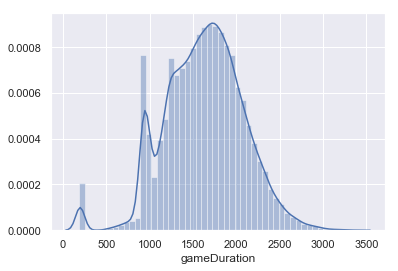

In [3]:
import seaborn as sns
sns.set();
sns.distplot(df2['gameDuration'])

- 构造两队总经济这一特征

In [4]:
name='player{}_goldEarned'
df['gold_all']=0
for i in range(10):
    df['gold_all']+=df[name.format(str(int(i+1)))]

- 画出总经济与游戏时长之间的关系图
    - 发现大致呈现正相关
    - 且有线性关系
    - 好像不同有不同的线性关系

Text(0,0.5,'gameDuration')

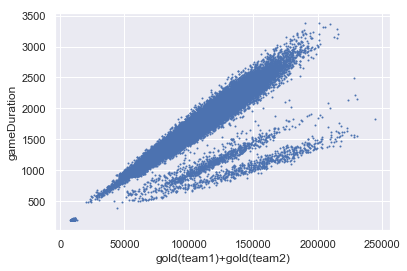

In [142]:
plt.scatter(df.loc[20000:,'gold_all'],df.loc[20000:,'gameDuration'],s=1)
plt.xlabel('gold(team1)+gold(team2)')
plt.ylabel('gameDuration')

- 猜想不同的mapId可能会导致不同的线性关系
    - Amazing!
    - 在数据较少的map12，发现了良好的线性关系

In [6]:
df['mapId'].value_counts()

11    79001
12      999
Name: mapId, dtype: int64

Text(0,0.5,'gameDuration')

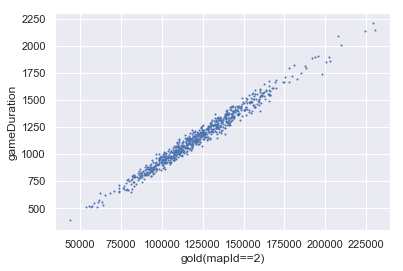

In [143]:
df_map2=df[df['mapId']==12]
plt.scatter(df_map2.loc[20000:,'gold_all'],df_map2.loc[20000:,'gameDuration'],s=1)
plt.xlabel('gold(mapId==2)')
plt.ylabel('gameDuration')

- 获取数据集和测试集中map12的数据个数
    - 数据集中有764
    - 测试集中有235
    - 可以勉强用764条数据来做预测

In [8]:
print(len(df[(df['index']>20000)&(df['mapId']==12 )].index))
print(len(df[(df['index']<20000)&(df['mapId']==12 )].index))

764
235


- 获取map为11的数据
    - 画图发现还是有不同的线性关系
    - 但是中间的线性关系数据点减少了

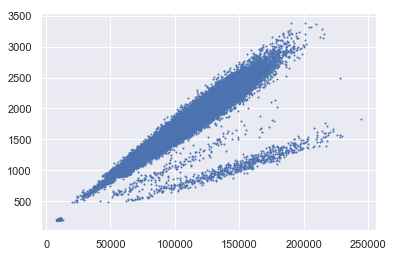

In [9]:
df_map1=df.copy()
df_map1.drop(df[df['mapId']==12].index,inplace=True)
plt.scatter(df_map1.loc[20000:,'gold_all'],df_map1.loc[20000:,'gameDuration'],s=1)

- 进一步怀疑可能是queueId不同
    - 对不同的queueId分别作出散点图看关系

In [10]:
df['queueId'].value_counts()

420     50146
430     20966
440      4016
700      2594
900      1023
450       999
1020      256
Name: queueId, dtype: int64

- 可以发现不同的queueId下，游戏时长与经济和有着很强的线性关系

Text(0,0.5,'gameDuration')

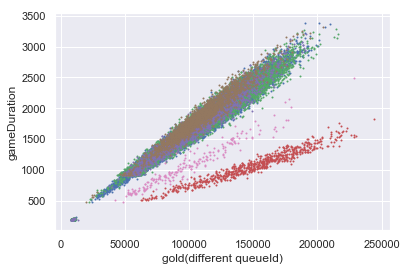

In [144]:
for num in df['queueId'].unique():
    exec("df_qid%s=df_map1[df_map1['queueId']==%s]"%(num,num))
    exec("plt.scatter(df_qid%s.loc[20000:,'gold_all'],df_qid%s.loc[20000:,'gameDuration'],s=1)"%(num,num))
plt.xlabel('gold(different queueId)')
plt.ylabel('gameDuration')

- 看一下不同queueId的数据在数据集和测试集内的分布
    - 数据规模都大致可以对测试集进行预测
    - 不存在某个测试集有，但数据集没有的queue

In [12]:
for num in df['queueId'].unique():
    print('queueId为'+str(num)+'的分布为: 数据集',end='')
    exec("print(len(df[(df['index']>20000)&(df['queueId']==%s )].index),end='')"%num)
    print('个，测试集',end='')
    exec("print(len(df[(df['index']<20000)&(df['queueId']==%s )].index),end='')"%num)
    print('个',end='\n')

queueId为420的分布为: 数据集37107个，测试集13038个
queueId为450的分布为: 数据集764个，测试集235个
queueId为430的分布为: 数据集16148个，测试集4818个
queueId为900的分布为: 数据集677个，测试集346个
queueId为440的分布为: 数据集3142个，测试集874个
queueId为700的分布为: 数据集1953个，测试集641个
queueId为1020的分布为: 数据集208个，测试集48个


## 下面开始真正的机器学习内容

### 首先试验一下线性拟合

In [13]:
#导入线性回归模型：
from sklearn.linear_model import LinearRegression
#随机划分样本数据为训练集和测试集
from sklearn.model_selection import train_test_split


In [14]:
#对map12数据进行线性回归
train_data_map2=pd.DataFrame(df_map2.loc[20000:,'gold_all'])
train_target_map2=pd.DataFrame(df_map2.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_map2,train_target_map2,test_size=0.3)
reg=LinearRegression()
reg.fit(train_X,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

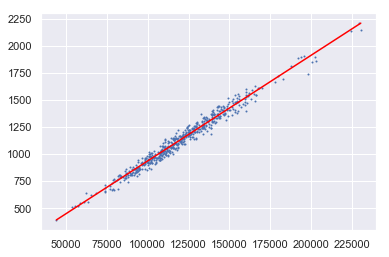

In [15]:
#看一下在数据集中划分的数据集上的拟合结果
z=np.linspace(train_data_map2.min(),train_data_map2.max(),200).reshape(-1,1)
plt.scatter(train_X,train_y,s=1)
plt.plot(z,reg.predict(z),c="red")
plt.show()

In [16]:
#看一下拟合结果在数据集上划分的测试集的准确性
test_y_pred=reg.predict(test_X)
#均方误差
print(sklearn.metrics.mean_squared_error(test_y_pred,test_y))
#r^2值,拟合效果不错
print(sklearn.metrics.r2_score(test_y_pred,test_y))

2036.598214861877
0.9697413468057989


In [17]:
#获取真正的测试集的数据
real_test_df_map2=pd.DataFrame(df[(df['mapId']==12)&(df['index']<=20000)]['gold_all'])
real_test_df_map2['gameDuration']=reg.predict(real_test_df_map2)

queueId=420,均方误差为5783.780792630833,r^2值为0.9672164803871554
queueId=430,均方误差为7401.02399640444,r^2值为0.9683878551451761
queueId=900,均方误差为4017.379766546062,r^2值为0.9263420735973984
queueId=440,均方误差为8488.028398150529,r^2值为0.955479866272224
queueId=700,均方误差为8565.232767616548,r^2值为0.9437498580745465
queueId=1020,均方误差为3863.6860121641444,r^2值为0.9662429396593402
总误差为6432.721261357014


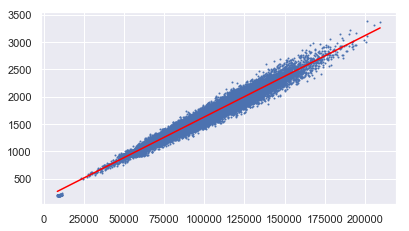

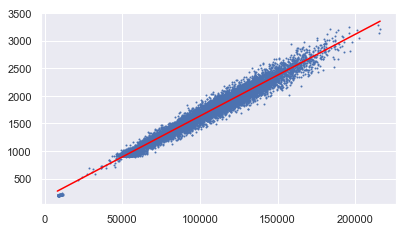

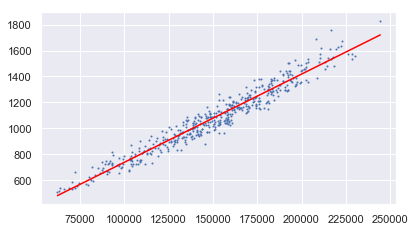

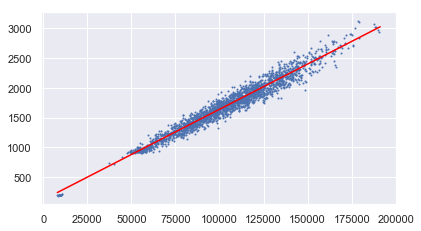

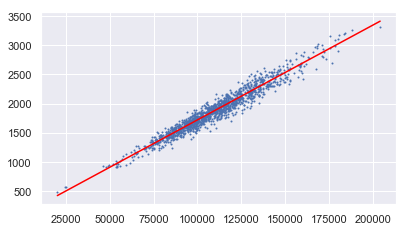

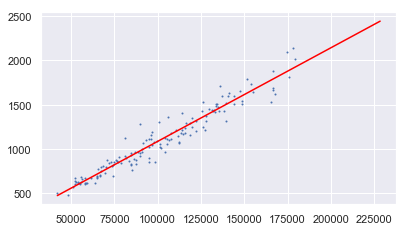

In [88]:
#对剩余的queue采取线性回归
error_lg=0
len_test=0
num_list=list(df_map1['queueId'].unique())
for i in range(len(num_list)):
    num=num_list[i]
    exec("train_data_qid%s=pd.DataFrame(df_qid%s.loc[20000:,'gold_all'])"%(num,num))
    exec("train_target_qid%s=pd.DataFrame(df_qid%s.loc[20000:,'gameDuration'])"%(num,num))
    exec("train_X,test_X,train_y,test_y = train_test_split(train_data_qid%s,train_target_qid%s,test_size=0.3)"%(num,num))
    reg=LinearRegression()
    reg.fit(train_X,train_y)
    exec("z=np.linspace(train_data_qid%s.min(),train_data_qid%s.max(),200).reshape(-1,1)"%(num,num))
    plt.figure(figsize=(14,12))
    plt.subplot(3,2,i+1)
    plt.scatter(train_X,train_y,s=1)
    plt.plot(z,reg.predict(z),c="red")
    #看一下拟合结果在数据集上划分的测试集的准确性
    test_y_pred=reg.predict(test_X)
    print('queueId='+str(num)+',均方误差为',end='')
    #均方误差
    error=sklearn.metrics.mean_squared_error(test_y_pred,test_y)
    print(error,end='')
    error_lg+=error*len(test_y)
    len_test+=len(test_y)
    print(',r^2值为',end='')
    #r^2值,拟合效果不错
    print(sklearn.metrics.r2_score(test_y_pred,test_y))
print('总平均误差为'+str(error_lg/len_test))

In [89]:
#获取真正的测试集的数据
num_list=list(df_map1['queueId'].unique())
for i in range(len(num_list)):
    num=num_list[i]
    exec("train_X,test_X,train_y,test_y = train_test_split(train_data_qid%s,train_target_qid%s,test_size=0.3)"%(num,num))
    reg=LinearRegression()
    reg.fit(train_X,train_y)
    exec("real_test_df_qid%s=pd.DataFrame(df_map1[(df_map1['queueId']==%s)&(df['index']<=20000)]['gold_all'])"%(num,num))
    exec("real_test_df_qid%s['gameDuration']=reg.predict(real_test_df_qid%s)"%(num,num))

C:\Users\86136\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\86136\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\86136\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\86136\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\86136\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFra

In [90]:
dfdf=df.copy()
num_list=list(df_map1['queueId'].unique())
for i in range(len(num_list)):
    num=num_list[i]
    exec("dfdf['gameDuration'].fillna(real_test_df_qid%s['gameDuration'],inplace=True)"%num)
dfdf['gameDuration'].fillna(real_test_df_map2['gameDuration'],inplace=True)

In [91]:
df_result1=dfdf.loc[:20000,'gameDuration']
df_result1.to_csv('C:/Users/86136/Desktop/大学/大二下/数据分析/实验/exp4/result1.csv')

### 下面试一下用KNN算法

In [24]:
df['team1_gold']=0
df['team2_gold']=0
for i in range(1,6):
    df['team1_gold']+=df[name.format(str(i))]
    df['team2_gold']+=df[name.format(str(i+5))]

- 特征是两队的总经济

In [93]:
train_data_knn=df.loc[20000:,['team1_gold','team2_gold']]
train_target_knn=pd.DataFrame(df.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_knn,train_target_knn,test_size=0.3,random_state=1)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [94]:
mse_list=[]
n_min=31
n_max=61
for i in range(n_min,n_max):
    knn = KNeighborsRegressor(i)

    knn.fit(train_X, train_y)
    pred_y = knn.predict(test_X)
    mse = mean_squared_error(pred_y,test_y)
    mse_list.append(mse)

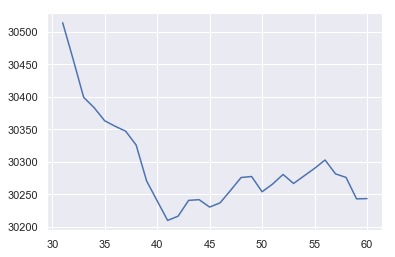

In [44]:
n_list=list(range(n_min,n_max))
plt.plot(n_list[:],mse_list[:])
# plt.scatter(n_list[50],mse_list[50],c='red',s=10)

- 效果太差，总误差30000+

- 特征是两队总经济和queueId

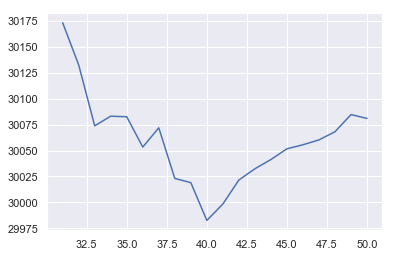

In [48]:
train_data_knn2=df.loc[20000:,['team1_gold','team2_gold','queueId']]
train_target_knn2=pd.DataFrame(df.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_knn2,train_target_knn2,test_size=0.3,random_state=1)
mse_list=[]
n_min=31
n_max=51
for i in range(n_min,n_max):
    knn2 = KNeighborsRegressor(i)
    knn2.fit(train_X, train_y)
    pred_y = knn2.predict(test_X)
    mse = mean_squared_error(pred_y,test_y)
    mse_list.append(mse)
n_list=list(range(n_min,n_max))
plt.plot(n_list[:],mse_list[:])

- 效果优于两特征的KNN算法,但还是很差

- 对于每个queueId应用KNN算法
    - 效果略逊于线性回归（6900+>6300+）
    - 但可以一用

总平均误差为8104.759003824304


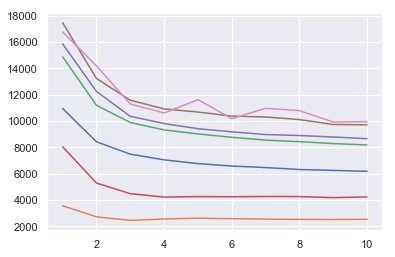

In [152]:
num_list2=df['queueId'].unique()
# num_list2(450)
error_knn=0
len_knn=0
for j in range(len(num_list2)):
    num=num_list2[j]
    exec("train_data_knn2_qid%s=df[df['queueId']==%s].loc[20000:,['team1_gold','team2_gold']]"%(num,num))
    exec("train_target_knn2_qid%s=pd.DataFrame(df[df['queueId']==%s].loc[20000:,'gameDuration'])"%(num,num))
    exec("train_X,test_X,train_y,test_y = train_test_split(train_data_knn2_qid%s,train_target_knn2_qid%s,test_size=0.3,random_state=1)"%(num,num))
    mse_list=[]
    n_min=1
    n_max=11
    for i in range(n_min,n_max):
        knn2 = KNeighborsRegressor(i)
        knn2.fit(train_X, train_y)
        pred_y = knn2.predict(test_X)
        mse = mean_squared_error(pred_y,test_y)
        mse_list.append(mse)
        error_knn+=mse*len(test_y)
        len_knn+=len(test_y)
    n_list=list(range(n_min,n_max))
    plt.plot(n_list[:],mse_list[:])
print('总平均误差为'+str(error_knn/len_knn))

- 获取预测数据

In [116]:
for j in range(len(num_list2)):
    num=num_list2[j]
    exec("train_data_knn2_qid%s=df[df['queueId']==%s].loc[20000:,['team1_gold','team2_gold']]"%(num,num))
    exec("train_target_knn2_qid%s=pd.DataFrame(df[df['queueId']==%s].loc[20000:,'gameDuration'])"%(num,num))
    exec("train_X,test_X,train_y,test_y = train_test_split(train_data_knn2_qid%s,train_target_knn2_qid%s,test_size=0.3,random_state=1)"%(num,num))
    exec("real_test_knn_qid%s=df[df['queueId']==%s].loc[:20000,['team1_gold','team2_gold']]"%(num,num))
    knn2 = KNeighborsRegressor(10)
    knn2.fit(train_X, train_y)
#     exec("real_test_knn_qid%s['gameDuration']= 0"%num)
    exec("real_test_knn_qid%s['gameDuration']= knn2.predict(real_test_knn_qid%s)"%(num,num))

- 合并dataframe，写入文件

In [124]:
df_knn=df.copy()
for i in range(len(num_list2)):
    num=num_list2[i]
    exec("df_knn['gameDuration'].fillna(real_test_knn_qid%s['gameDuration'],inplace=True)"%num)
# dfdf['gameDuration'].fillna(real_test_df_map2['gameDuration'],inplace=True)

df_result2=pd.DataFrame(df_knn['gameDuration'],columns=['gameDuration'])
df_result2.to_csv('C:/Users/86136/Desktop/大学/大二下/数据分析/实验/exp4/result2.csv')

### 下面用决策树算法试一试

- 直接用两队的总经济
    - 效果太差！58000+

In [129]:
from sklearn import tree
train_data_c45=df.loc[20000:,['team1_gold','team2_gold']]
train_target_c45=pd.DataFrame(df.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_c45,train_target_c45,test_size=0.3,random_state=1)
c45 = tree.DecisionTreeClassifier()
c45.fit(train_X,train_y)
pred_y=c45.predict(test_X)
mean_squared_error(pred_y,test_y)

58797.603777777775

- 加上queueId试一下
    - 效果依旧爆炸！23000+
    - 不过比上一个好

In [130]:
train_data_knn=df.loc[20000:,['team1_gold','team2_gold','queueId']]
train_target_knn=pd.DataFrame(df.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_knn,train_target_knn,test_size=0.3,random_state=1)
c45 = tree.DecisionTreeClassifier()
c45.fit(train_X,train_y)
pred_y=c45.predict(test_X)
mean_squared_error(pred_y,test_y)

23830.403444444444

- 对不同的queueId分别使用
    - 效果不如KNN和linear regression方法
    - gini 9665； entropy 10558

In [132]:
num_list3=df['queueId'].unique()
error_c45=0
len_c45=0
for j in range(len(num_list3)):
    num=num_list3[j]
    exec("train_data_c45_qid%s=df[df['queueId']==%s].loc[20000:,['team1_gold','team2_gold']]"%(num,num))
    exec("train_target_c45_qid%s=pd.DataFrame(df[df['queueId']==%s].loc[20000:,'gameDuration'])"%(num,num))
    exec("train_X,test_X,train_y,test_y = train_test_split(train_data_c45_qid%s,train_target_c45_qid%s,test_size=0.3,random_state=1)"%(num,num))
    c45 = tree.DecisionTreeClassifier(criterion='entropy')
    c45.fit(train_X,train_y)
    pred_y = c45.predict(test_X)
    mse = mean_squared_error(pred_y,test_y)
    error_knn+=mse*len(test_y)
    len_knn+=len(test_y)
print('总平均误差为'+str(error_knn/len_knn))

总平均误差为10558.437211915872


### 下面试验一下贝叶斯方法

- 直接用两队的总经济
    - 效果太差！40000+

In [135]:
from sklearn.naive_bayes import GaussianNB
train_data_bay=df.loc[20000:,['team1_gold','team2_gold']]
train_target_bay=pd.DataFrame(df.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_bay,train_target_bay,test_size=0.3,random_state=1)
gnb = GaussianNB()
gnb.fit(train_X,train_y)
pred_y=gnb.predict(test_X)
mean_squared_error(pred_y,test_y)

C:\Users\86136\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


40812.60255555555

- 加上queueId试一下
    - 效果依旧爆炸！33000+
    - 不过比上一个好

In [136]:
from sklearn.naive_bayes import GaussianNB
train_data_bay=df.loc[20000:,['team1_gold','team2_gold','queueId']]
train_target_bay=pd.DataFrame(df.loc[20000:,'gameDuration'])
train_X,test_X,train_y,test_y = train_test_split(train_data_bay,train_target_bay,test_size=0.3,random_state=1)
gnb = GaussianNB()
gnb.fit(train_X,train_y)
pred_y=gnb.predict(test_X)
mean_squared_error(pred_y,test_y)

C:\Users\86136\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33294.662833333336

- 对不同的queueId分别使用
    - 效果不如KNN和linear regression方法 9000+

In [139]:
num_list4=df['queueId'].unique()
error_bay=0
len_bay=0
for j in range(len(num_list4)):
    num=num_list4[j]
    exec("train_data_bay_qid%s=df[df['queueId']==%s].loc[20000:,['team1_gold','team2_gold']]"%(num,num))
    exec("train_target_bay_qid%s=pd.DataFrame(df[df['queueId']==%s].loc[20000:,'gameDuration'])"%(num,num))
    exec("train_X,test_X,train_y,test_y = train_test_split(train_data_bay_qid%s,train_target_bay_qid%s,test_size=0.3,random_state=1)"%(num,num))
    gnb = GaussianNB()
    gnb.fit(train_X,train_y)
    pred_y=gnb.predict(test_X)
    mse = mean_squared_error(pred_y,test_y)
    error_bay+=mse*len(test_y)
    len_bay+=len(test_y)
print('总平均误差为'+str(error_bay/len_bay))

总平均误差为9612.669462341702
